# Libreries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

sns.set_theme(style="whitegrid")

# Support Functions

In [2]:
# Function to print metrics and plot predicted vs actual values
def print_metrics(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {label} ---")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    
    # Scatter plot predicted vs actual
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='steelblue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{label}: Actual vs Predicted')
    plt.grid(True)
    plt.show()
    
# Function to plot top feature importances and cumulative importance
def plot_feature_importance_cumulative(importances, feature_names, top_n=15):
    # Sort importances
    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_features = [feature_names[i] for i in indices]
    
    # Bar plot top_n features
    plt.figure(figsize=(10,5))
    sns.barplot(x=sorted_importances[:top_n], y=sorted_features[:top_n], palette='viridis')
    plt.title(f"Top {top_n} Feature Importances")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
    # Cumulative importance plot
    cumulative_importance = np.cumsum(sorted_importances)
    plt.figure(figsize=(10,5))
    plt.plot(range(1,len(cumulative_importance)+1), cumulative_importance, marker='o', color='purple')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.grid(True)
    plt.show()

# Load Data 

In [3]:
# Load training and testing datasets
train_df = pd.read_csv('/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/train70_clf.csv')
test_df = pd.read_csv('/Users/chiaraferrara/Desktop/Unipi/Magistrale/DM 2/dm2_project/dm2_dataset_2425_imdb/test30_clf.csv')

# Separate features and target
X_train = train_df.drop(columns=['averageRating'])
y_train = train_df['averageRating']
X_test = test_df.drop(columns=['averageRating'])
y_test = test_df['averageRating']

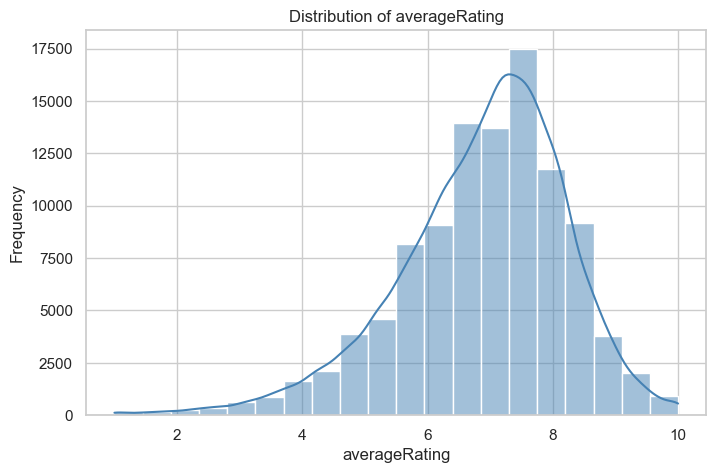

Correlation of numeric features with averageRating:
 averageRating        1.000000
startYear            0.201523
genre3               0.081623
genre2               0.069192
genre1               0.057516
deltaCredits         0.038151
totalNominations     0.017257
canHaveEpisodes      0.017038
ratingCount          0.016927
totalMedia           0.001857
totalReviews        -0.014358
companiesNumber     -0.016836
Africa              -0.029304
Asia                -0.040652
Oceania             -0.075216
South America       -0.100546
Europe              -0.115636
Continent Unknown   -0.121830
numRegions          -0.125410
North America       -0.152312
runtimeMinutes      -0.163336
Name: averageRating, dtype: float64


In [4]:
# Plot distribution of target variable
plt.figure(figsize=(8,5))
sns.histplot(y_train, kde=True, bins=20, color='steelblue')
plt.title('Distribution of averageRating')
plt.xlabel('averageRating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Compute correlation of numeric features with target
numeric_cols = train_df.select_dtypes(include=np.number).columns
corr_with_target = train_df[numeric_cols].corr()['averageRating'].sort_values(ascending=False)
print("Correlation of numeric features with averageRating:\n", corr_with_target)

# Preprocessing

In [5]:
# Define numeric and categorical features
numeric_features = [col for col in X_train.columns if col not in ['canHaveEpisodes','titleType']]
categorical_features = ['canHaveEpisodes','titleType']

# Define transformers
numeric_transformer = StandardScaler()  # scale numeric features
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')  # encode categorical features

# ColumnTransformer applies transformations to correct columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create pipeline with preprocessing and RF model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Hyperparameter Tuning with RandomizedSearchCV

In [6]:
param_dist = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 10, 15, 20, 25, 30],
    'rf__min_samples_split': [2, 5, 10, 15],
    'rf__min_samples_leaf': [1, 2, 4, 6],
    'rf__max_features': ['sqrt', 'log2']  # limitato a sqrt e log2
}

random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='r2',
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)
best_pipeline = random_search.best_estimator_
print("\nBest RF Parameters:", random_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=200; total time=   3.3s
[CV] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=200; total time=   3.2s
[CV] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=200; total time=   3.2s
[CV] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=200; total time=   3.2s
[CV] END rf__max_depth=30, rf__max_features=sqrt, rf__min_samples_leaf=2, rf__min_samples_split=15, rf__n_estimators=200; total time=   3.2s
[CV] END rf__max_depth=15, rf__max_features=log2, rf__min_samples_leaf=6, rf__min_samples_split=15, rf__n_estimators=300; total time=   3.0s
[CV] END rf__max_depth=15, rf__max_features=log2, rf__min_samples_leaf=6, rf__min_samples_sp

## Evaluate Model and feature Importance top 20


--- Test Best RF ---
MAE: 0.7544
MSE: 1.0893
R2: 0.4055


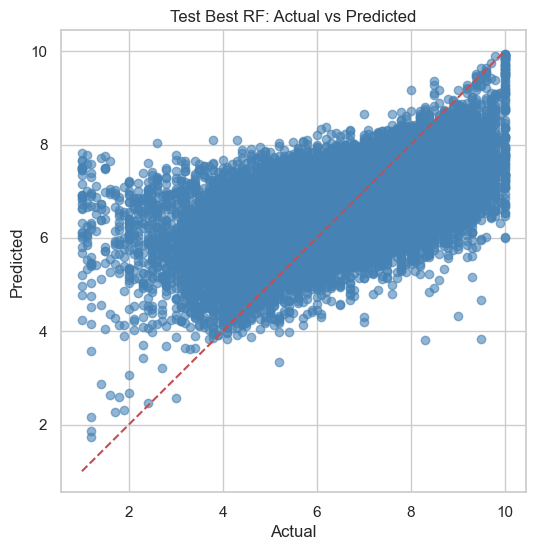

/var/folders/gv/llgn_fqn7d1fy23dylt643b80000gn/T/ipykernel_37985/4186402924.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances[:top_n], y=sorted_features[:top_n], palette='viridis')


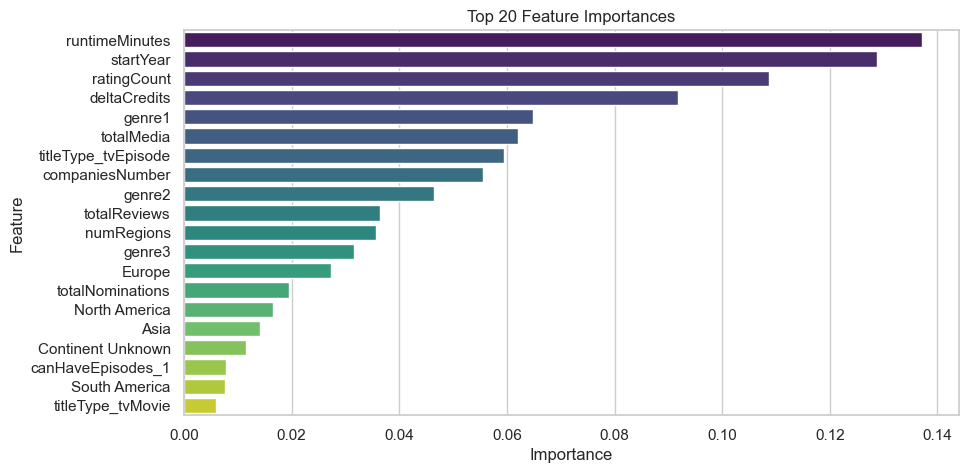

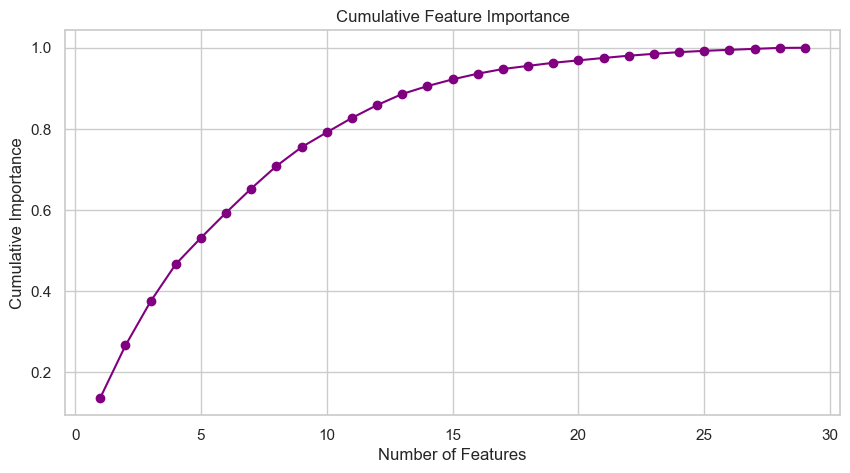

In [7]:
y_pred_test = best_pipeline.predict(X_test)
print_metrics(y_test, y_pred_test, "Test Best RF")

# Get feature names after preprocessing
ohe_features = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(ohe_features)
importances = best_pipeline.named_steps['rf'].feature_importances_

# Plot top 15 features and cumulative importance
plot_feature_importance_cumulative(importances, all_features, top_n=20)

# Refit RF with Top 20 Features


--- RF with Top 20 Features ---
MAE: 0.7529
MSE: 1.0891
R2: 0.4056


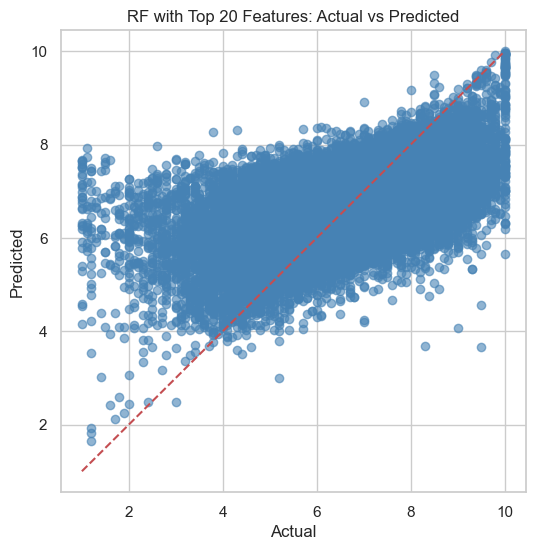

In [8]:
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]
top_features = [all_features[i] for i in indices]

# Extract top features from preprocessed data
X_train_top = best_pipeline.named_steps['preprocessor'].transform(X_train)[:, indices]
X_test_top = best_pipeline.named_steps['preprocessor'].transform(X_test)[:, indices]

# Refit RF on top 15 features
rf_top = RandomForestRegressor(
    n_estimators=random_search.best_params_['rf__n_estimators'],
    max_depth=random_search.best_params_['rf__max_depth'],
    min_samples_split=random_search.best_params_['rf__min_samples_split'],
    min_samples_leaf=random_search.best_params_['rf__min_samples_leaf'],
    max_features=random_search.best_params_['rf__max_features'],
    random_state=42,
    n_jobs=-1
)
rf_top.fit(X_train_top, y_train)
y_pred_top = rf_top.predict(X_test_top)
print_metrics(y_test, y_pred_top, f"RF with Top {top_n} Features")

## Cross-Validation and Residual Analysis

5-Fold CV R2 scores: [0.38564494 0.39213376 0.40208845 0.39112669 0.38870023]
Mean CV R2: 0.3919, Std: 0.0055


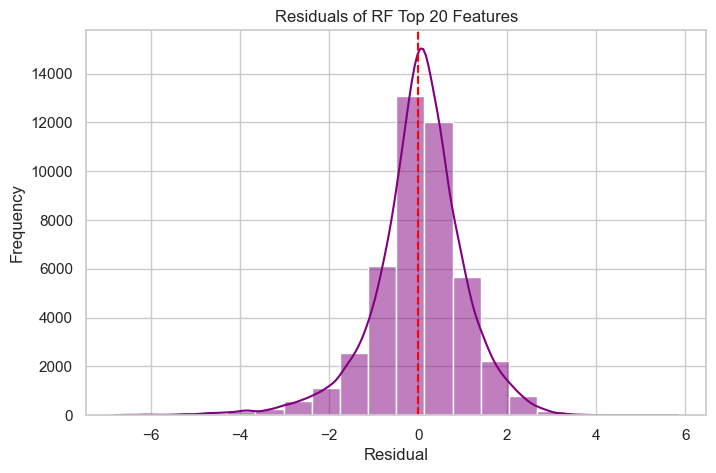

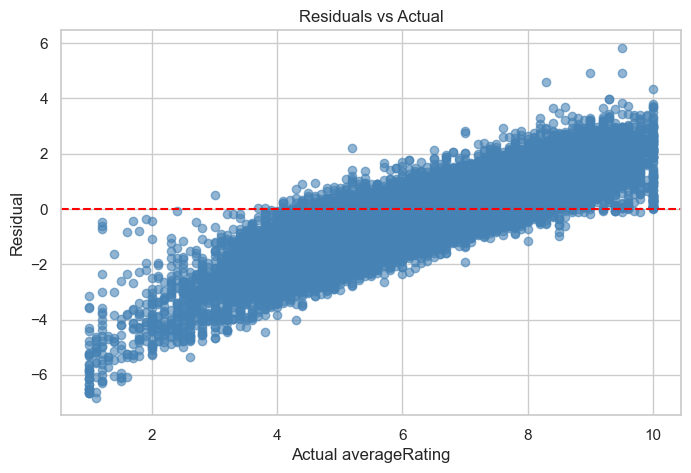

In [9]:
cv_scores = cross_val_score(rf_top, X_train_top, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"5-Fold CV R2 scores: {cv_scores}")
print(f"Mean CV R2: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

residuals = y_test - y_pred_top

# Residual histogram
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=20, kde=True, color='purple')
plt.axvline(0,color='red',linestyle='--')
plt.title('Residuals of RF Top 20 Features')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual scatter plot
plt.figure(figsize=(8,5))
plt.scatter(y_test,residuals,alpha=0.6, color='steelblue')
plt.axhline(0,color='red',linestyle='--')
plt.xlabel('Actual averageRating')
plt.ylabel('Residual')
plt.title('Residuals vs Actual')
plt.grid(True)
plt.show()